# Figure 3
Here, Figure 3 is created. Currently the plotting code and the simulation code is interleaved - this should be cleaned up. One expection is the FORCE simulation, which is in `FORCE non-orthogonal Q.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import tqdm
import nengo
sns.set_context("paper")
sns.set_style("white")

In [121]:
store = pd.HDFStore("../generatedData/fig3.h5")

In [122]:
keys = store.keys()

In [123]:
df = pd.DataFrame([k.split("/")[1:] for k in keys], columns=["network", "perturbation", "i", "which", "matrix"])

In [124]:
similarities = []
for g, _ in tqdm.tqdm(df.groupby(["network", "perturbation", "i"])):
    origEta = pd.read_hdf(store, "/"+"/".join(g)+"/original/K")
    origPhi = pd.read_hdf(store, "/"+"/".join(g)+"/original/phi")
    pertEta = pd.read_hdf(store, "/"+"/".join(g)+"/perturbed/K")
    pertPhi = pd.read_hdf(store, "/"+"/".join(g)+"/perturbed/phi")
    origW = origEta.values.dot(origPhi.values.T)
    pertW = pertEta.values.dot(pertPhi.values.T)
    corr = scipy.stats.pearsonr(origW.flat, pertW.flat)[0]
    l2 = np.sqrt(np.sum((origW - pertW)**2))
    similarities.append(g + (corr, l2))
    
for i in tqdm.trange(1,31):
    origEta = pd.read_hdf(store, "/force/identity/%d/original/K"%i)
    origPhi = pd.read_hdf(store, "/force/identity/%d/original/phi"%i)
    pertEta = pd.read_hdf(store, "/force/permutation/%d/original/K"%i)
    pertPhi = pd.read_hdf(store, "/force/permutation/%d/original/phi"%i)
    origW = origEta.values.dot(origPhi.values.T)
    pertW = pertEta.values.dot(pertPhi.values.T)
    corr = scipy.stats.pearsonr(origW.flat, pertW.flat)[0]
    l2 = np.sqrt(np.sum((origW - pertW)**2))
    similarities.append(("force", "unrelated", i) + (corr, l2))
similarities = pd.DataFrame(similarities, columns=["network", "perturbation", "i", "correlation", "l2"])


100%|██████████| 179/179 [00:16<00:00, 10.98it/s]

100%|██████████| 30/30 [00:02<00:00, 11.39it/s]


In [125]:
store.close()

In [101]:
def testEfficientCodingCorr(Q, D=2):
    K = np.random.normal(0,0.2,(1000,D))
    Phi = K.T
    origW = np.dot(K,Phi)
    pertK = np.dot(K,Q)
    pertK -= pertK.mean()
    pertK /= pertK.std()/0.2
    pertW = np.dot(pertK, pertK.T)
    corr = scipy.stats.pearsonr(origW.flat, pertW.flat)
    return corr[0], np.sqrt(np.sum((origW - pertW)**2))

In [9]:
def phaseIn(t, x):
    t *= 2
    frac = np.clip(t%1.0 - 0.15, 0, 0.3) / 0.3
    return frac*x

signal = np.array([[0.2, 0.6, 0.0, -0.7, -0.2], [0.0, -0.3, 0.2, 0.0, 0.5]]).T
def drive(t):
    t *= 2
    frac = np.clip(t%1.0 - 0.15, 0, 0.3) / 0.3
    return (1-frac)*signal[np.clip(int(t%5), 0, 4)]

def runNEFNetwork(encoders=None):
    model = nengo.Network(label="Integrator")
    noiseProcess = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 7e-3), seed=1)
    
    N = 1000
    K = 2
    with model:
        if encoders is None:
            A = nengo.Ensemble(N, dimensions=K, max_rates=nengo.dists.Uniform(80,120))
        else:
            A = nengo.Ensemble(N, dimensions=K, encoders=encoders)
        tau = 0.01 #Synaptic time constant is 10 ms
        input = nengo.Node(drive, 0, 2)
        input_connection = nengo.Connection(input, A, synapse=tau)
        node = nengo.Node(phaseIn, 2, 2)
        recurrent_connection = nengo.Connection(A, node, synapse=tau)
        feedback_connection = nengo.Connection(node, A)
        A_probe = nengo.Probe(A, synapse=tau)
        spikes_probe = nengo.Probe(A.neurons)
    sim = nengo.Simulator(model, progress_bar=False)
    sim.run(0.1, False)
    eta = sim.data[A].encoders
    phi = sim.data[recurrent_connection].weights
    return eta, phi

def testNEFCodingCorr(Q):
    origEta, origPhi = runNEFNetwork()
    pertEta, pertPhi = runNEFNetwork(origEta.dot(Q))
    origW = np.dot(origEta, origPhi)
    pertW = np.dot(pertEta, pertPhi)
    return scipy.stats.pearsonr(origW.flat, pertW.flat)[0], np.sqrt(np.sum((origW - pertW)**2))

In [10]:
def testEfficientCodingCorrOuter(D=2):
    ind = np.concatenate((np.arange(500,1000), np.arange(0,500)))
    K = np.random.normal(0,0.2,(1000,D))
    Phi = K.T
    origW = np.dot(K,Phi)
    pertW = np.dot(K[ind,:], Phi[:,ind])
    corr = scipy.stats.pearsonr(origW.flat, pertW.flat)
    return corr[0], np.sqrt(np.sum((origW - pertW)**2))

def testNEFCodingCorrOuter():
    ind = np.concatenate((np.arange(500,1000), np.arange(0,500)))
    origEta, origPhi = runNEFNetwork()
    pertEta, pertPhi = runNEFNetwork(origEta[ind,:])
    origW = np.dot(origEta, origPhi)
    pertW = np.dot(pertEta, pertPhi)
    return scipy.stats.pearsonr(origW.flat, pertW.flat)[0], np.sqrt(np.sum((origW - pertW)**2))

In [46]:
def testNEFCodingCorrUnrelated():
    ind = np.concatenate((np.arange(500,1000), np.arange(0,500)))
    origEta, origPhi = runNEFNetwork()
    pertEta, pertPhi = runNEFNetwork()
    origW = np.dot(origEta, origPhi)
    pertW = np.dot(pertEta, pertPhi)
    return scipy.stats.pearsonr(origW.flat, pertW.flat)[0], np.sqrt(np.sum((origW - pertW)**2))

def testEfficientCodingCorrUnrelated(D=2):
    ind = np.concatenate((np.arange(500,1000), np.arange(0,500)))
    K = np.random.normal(0,0.2,(1000,D))
    Phi = K.T
    origW = np.dot(K,Phi)
    pertK = np.random.normal(0,0.2,(1000,D))
    pertPhi = pertK.T
    pertW = np.dot(pertK, pertPhi)
    corr = scipy.stats.pearsonr(origW.flat, pertW.flat)
    return corr[0], np.sqrt(np.sum((origW - pertW)**2))

In [27]:
#def normalizeMatrix(Q):
#    Q /= (Q**2).sum(axis=1)[:,np.newaxis]
#    Q /= (Q**2).sum(axis=0)[np.newaxis,:]
#    return Q

In [102]:
nSamples = 30

identityQ_ec = [testEfficientCodingCorr(np.eye(2)) for _ in tqdm.trange(nSamples)]
permQ_ec = [testEfficientCodingCorr(np.array([[0,1],[1,0]])) for _ in tqdm.trange(nSamples)]
normalQ_ec = [testEfficientCodingCorr(np.random.normal(0,1,(2,2))) for _ in tqdm.trange(nSamples)]
fixedQ_ec = [testEfficientCodingCorr(np.random.normal(0,1) * np.ones((2,2))) for _ in tqdm.trange(nSamples)]


100%|██████████| 30/30 [00:02<00:00, 10.37it/s]

100%|██████████| 30/30 [00:02<00:00,  8.35it/s]

100%|██████████| 30/30 [00:02<00:00, 15.22it/s]

100%|██████████| 30/30 [00:01<00:00, 16.46it/s]


In [ ]:
identityQ_nef = [testNEFCodingCorr(np.eye(2)) for _ in tqdm.trange(nSamples)]
permQ_nef = [testNEFCodingCorr(np.array([[0,1],[1,0]])) for _ in tqdm.trange(nSamples)]
normalQ_nef = [testNEFCodingCorr(np.random.normal(0,1,(2,2))) for _ in tqdm.trange(nSamples)]
fixedQ_nef = [testNEFCodingCorr(np.random.normal(0,1) * np.ones((2,2))) for _ in tqdm.trange(nSamples)]

In [107]:
deg = np.pi/4
rotQ = np.array([[np.cos(deg), -np.sin(deg)],[np.cos(deg), np.sin(deg)]])
rot45_ec = [testEfficientCodingCorr(rotQ) for _ in tqdm.trange(nSamples)]
rot45_nef = [testNEFCodingCorr(rotQ) for _ in tqdm.trange(nSamples)]


100%|██████████| 30/30 [00:02<00:00, 14.02it/s]

100%|██████████| 30/30 [00:53<00:00,  1.87s/it]


In [45]:
outer_ec = [testEfficientCodingCorrOuter() for _ in tqdm.trange(nSamples)]
outer_nef = [testNEFCodingCorrOuter() for _ in tqdm.trange(nSamples)]

100%|██████████| 30/30 [00:53<00:00,  1.86s/it]


In [47]:
unrel_ec = [testEfficientCodingCorrUnrelated() for _ in tqdm.trange(nSamples)]
unrel_nef = [testNEFCodingCorrUnrelated() for _ in tqdm.trange(nSamples)]

100%|██████████| 30/30 [00:54<00:00,  1.85s/it]


In [126]:
dfs = [similarities]

c = ["network", "perturbation", "i", "correlation", "l2"]

dfs.append(pd.DataFrame([("efficient_coding", "identity",i)+t for i,t in enumerate(identityQ_ec)], columns=c))
dfs.append(pd.DataFrame([("efficient_coding", "permutation",i)+t for i,t in enumerate(permQ_ec)], columns=c))
dfs.append(pd.DataFrame([("efficient_coding", "normal",i)+t for i,t in enumerate(normalQ_ec)], columns=c))
dfs.append(pd.DataFrame([("efficient_coding", "constant",i)+t for i,t in enumerate(fixedQ_ec)], columns=c))
dfs.append(pd.DataFrame([("efficient_coding", "rotation45", i)+t for i,t in enumerate(rot45_ec)], columns=c))
dfs.append(pd.DataFrame([("efficient_coding", "outerPermutation", i)+t for i,t in enumerate(outer_ec)], columns=c))
dfs.append(pd.DataFrame([("efficient_coding", "unrelated", i)+t for i,t in enumerate(unrel_ec)], columns=c))

dfs.append(pd.DataFrame([("nef", "identity",i)+t for i,t in enumerate(identityQ_nef)], columns=c))
dfs.append(pd.DataFrame([("nef", "permutation",i)+t for i,t in enumerate(permQ_nef)], columns=c))
dfs.append(pd.DataFrame([("nef", "normal",i)+t for i,t in enumerate(normalQ_nef)], columns=c))
dfs.append(pd.DataFrame([("nef", "constant",i)+t for i,t in enumerate(fixedQ_nef)], columns=c))
dfs.append(pd.DataFrame([("nef", "rotation45", i)+t for i,t in enumerate(rot45_nef)], columns=c))
dfs.append(pd.DataFrame([("nef", "outerPermutation", i)+t for i,t in enumerate(outer_nef)], columns=c))
dfs.append(pd.DataFrame([("nef", "unrelated", i)+t for i,t in enumerate(unrel_nef)], columns=c))

In [127]:
allDfs = pd.concat(dfs)

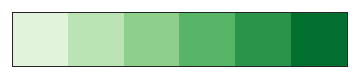

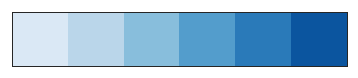

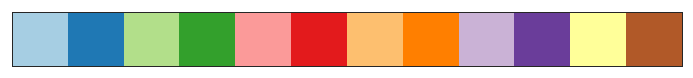

In [20]:
sns.palplot(sns.color_palette("Greens"))
sns.palplot(sns.color_palette("Blues"))
sns.palplot(sns.color_palette("Paired"))

In [4]:
palette = {
    'identity': sns.color_palette("Blues")[3],
    'permutation': sns.color_palette("Greens")[2],
    'rotation45': sns.color_palette("Greens")[3],
    'normal': sns.color_palette("Greens")[4],
    'constant': sns.color_palette("Greens")[5],
    'outerPermutation' : sns.color_palette("Reds")[-2],
    'unrelated' : sns.color_palette("Reds")[-1]
}

longerNames = {
    'identity': "No perturbation",
    'permutation':  "Permutation",
    'rotation45': "45 degree rotation",
    'normal': "Gaussian elements",
    'constant': "Same element",
    'outerPermutation' : "Outer permutation",
    'unrelated' : "Unrelated network"
}

palette = {longerNames[p]:c for p,c in palette.items()}

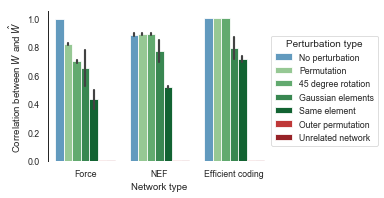

In [159]:
plt.figure(figsize=(4,2.75))
pertOrder = ["identity", "permutation", "rotation45", "normal", "constant", "outerPermutation", "unrelated"]
sns.barplot(data=allDfs.replace(longerNames), x="network", y="correlation", hue="perturbation", palette=palette,
            order=["force", "nef", "efficient_coding"], hue_order=[longerNames[p] for p in pertOrder], ci="sd")
sns.despine(bottom=True)
plt.legend(loc=(1.0,0.1), title="Perturbation type")
plt.ylabel("Correlation between $W$ and $\tilde{W}$")
plt.xlabel("Network type")
plt.gca().set_xticklabels(["Force","NEF", "Efficient coding"])
plt.savefig("fig3new_.svg")

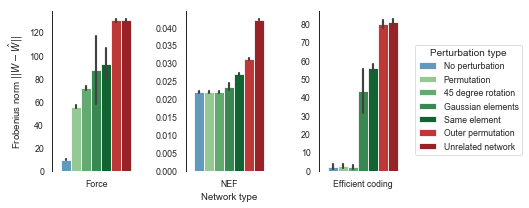

In [129]:
plt.figure(figsize=(7.5,3))
plt.subplot(1,3,1)
pertOrder = ["identity", "permutation", "rotation45", "normal", "constant", "outerPermutation", "unrelated"]
sns.barplot(data=allDfs.query("network=='force'").replace(longerNames), x="network", y="l2", hue="perturbation", palette=palette,
            hue_order=[longerNames[p] for p in pertOrder], ci="sd",)
sns.despine(bottom=True)
plt.ylabel("Frobenius norm $||W-\hat{W}||$")
plt.gca().set_xticklabels(["Force"])
plt.gca().get_legend().remove()
plt.xlabel("")

plt.subplot(1,3,2)
pertOrder = ["identity", "permutation", "rotation45", "normal", "constant", "outerPermutation", "unrelated"]
sns.barplot(data=allDfs.query("network=='nef'").replace(longerNames), x="network", y="l2", hue="perturbation", palette=palette,
            hue_order=[longerNames[p] for p in pertOrder], ci="sd",)
sns.despine(bottom=True)
plt.ylabel("")
plt.xlabel("Network type")
plt.gca().set_xticklabels(["NEF"])
plt.gca().get_legend().remove()

plt.subplot(1,3,3)
pertOrder = ["identity", "permutation", "rotation45", "normal", "constant", "outerPermutation", "unrelated"]
sns.barplot(data=allDfs.query("network=='efficient_coding'").replace(longerNames), x="network", y="l2", hue="perturbation", palette=palette,
            hue_order=[longerNames[p] for p in pertOrder], ci="sd",)
sns.despine(bottom=True)
plt.ylabel("")
plt.gca().set_xticklabels(["Efficient coding"])
#plt.ylim(0,12000)
#plt.gca().get_legend().remove()
plt.xlabel("")
plt.legend(loc=(1.1,0.1), title="Perturbation type")
plt.tight_layout()
plt.savefig("fig3new_l2.svg")

In [2]:
store = pd.HDFStore("./forceOtherQ.hdf")
i = 1
origEta = pd.read_hdf(store, "/force/permutation/%d/original/eta"%i)
origPhi = pd.read_hdf(store, "/force/permutation/%d/original/phi"%i)
pertEta = pd.read_hdf(store, "/force/permutation/%d/perturbed/eta"%i)
pertPhi = pd.read_hdf(store, "/force/permutation/%d/perturbed/phi"%i)
origW_inner = origEta.values.dot(origPhi.values.T)
pertW_inner = pertEta.values.dot(pertPhi.values.T)

origEta = pd.read_hdf(store, "/force/outerPermutation/%d/original/eta"%i)
origPhi = pd.read_hdf(store, "/force/outerPermutation/%d/original/phi"%i)
pertEta = pd.read_hdf(store, "/force/outerPermutation/%d/perturbed/eta"%i)
pertPhi = pd.read_hdf(store, "/force/outerPermutation/%d/perturbed/phi"%i)
origW_outer = origEta.values.dot(origPhi.values.T)
pertW_outer = pertEta.values.dot(pertPhi.values.T)
store.close()

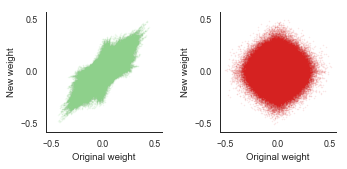

In [21]:
fig, axs = plt.subplots(1,2,sharex=True,figsize=(5.2, 2.2))
axs[0].plot(origW_inner.flat, pertW_inner.flat, '.', ms=1, alpha=0.1, color=palette["Permutation"])
axs[1].plot(origW_outer.flat, pertW_outer.flat, '.', ms=1, alpha=0.1, color=palette["Outer permutation"])
for ax in axs:
    ax.set_xlabel("Original weight")
    ax.set_ylabel("New weight")
    ax.set_yticks([-0.5,0,0.5])
    ax.axis("equal")
    #ax.set_xlim(-0.7,0.7)
    #ax.set_ylim(-0.7,0.7)
sns.despine(fig=fig)
plt.subplots_adjust(wspace=0.5)
#plt.savefig("fig3ab_new.svg", dpi=300)
plt.savefig("fig3ab_new.tif", dpi=300, frameon=False)